# Motivation

In my journey to explore the realm of data science, I embarked on a project aimed at mastering key modules such as Matplotlib, scikit-learn, and Pandas. Through this project, I endeavored to develop not only technical proficiency but also the ability to craft compelling narratives from data.

With this in mind, I got acquainted with the modules through the following task. I took on the task of plotting how my academic performance has evolved over time, leveraging data visualization techniques to enable meaningful comparisons. I also sought to create a model that can "predict" what my academic performance will be in the future. As this was my first time seriously working with these modules, I used a straightforward linear regression model for this purporse. I would like to clarify that this model was created to "have a little fun" and was not meant as a "serious model". For a meaningful model, one would need to divide the data into test (20% is the industry standard) and training (80%) sets and evaluate the model afterwards. I will attempt this in the future on another dataset with better explanatory variables. Overall, I achieved my goal of getting acquainted with the modules and telling a story using data.

## Dependencies

As of writing this, I have not provided a test pdf to use this notebook with, but I plan on doing so in the future.

If you are an RWTH student and would like to use this notebook for your own grades, you can readily do so. Simply download your report card "Notenspiegel(Alles)" and save it in the same folder as this file under "Notenspiegel.pdf" (Alternatively you can edit the file_path variable to the path of the document in the first code block).

### Other dependencies

This notebook uses the following. Please ensure you have Python and Java installed. When writing the execution instructions, I ke used VS code when writing down the execution instuctions, so if you are not familiar with venvs kindly download it, it provides a very easy way to create them without having to use the command line.

The remaining dependencies will be automatically installed, when you create the venv.

- [Python](https://www.python.org/) (version 3.12.2 or later)
- [Java](https://www.java.com/) (version 11.0.13 or later)
- [Pandas](https://pandas.pydata.org/) (version 2.2.1 or later)
- [Matplotlib](https://matplotlib.org/) (version 3.8.0 or later)
- [scikit-learn](https://scikit-learn.org/stable/) (version 1.3.0 or later)
- [tabula-py](https://github.com/chezou/tabula-py) (version 2.7.0 or later)
- [Ipython Kernel](https://ipython.org/) (version 6.29.3 or later)
- [jpype](https://github.com/jpype-project/jpype) (version 1.5.0 or later)

## Setting up a venv (in VS Code)

At this point, you should have already installed Python and java. Restart VS Code before proceeding (if you had already opened it).

### What is a venv (Virtual environment)?

Virtual environments are lightweight environments existing on top of the base Python installation, allowing different sets of packages to be installed in different directories. Why is this useful? Assume that you have a module that you use in some code that you wrote. It happens to be deprecated, but you haven't gotten around to updating your code. If you were to run this notebook, it may upgrade said depency to a newer verion and thus cause your code to break. By using venvs the required packages remain isolated from each other. 

While writing this, I used a conda environment, which is an analogous environment that is handled by the anaconda environment and package manager. Due to the fact that it would be another required install and it is not necessary, I listed the instructions for configuring a venv instead.

### Creating a venv 

Open VS Code and navigate to the folder that contains this file, in this folder, also include the requirements.txt document. When you open the folder in VS Code, you will need to select a kernel as to run this notebook. Click  "Select kernel" and then "Select another kernel". Create a new python environment, a venv, with Python 3.12 as the interpreter. Select requirements.txt and then click OK when it asks you which dependencies to install. Once the venv is created, you are ready to roll. Restart VS Code and everything should work from here on out.

In [1]:
import tabula
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from sklearn.linear_model import LinearRegression

tabula.environment_info()
#Let the file of your report card be in the same directory as this file, and have the title "Notenspiegel.pdf".
#Alternatively, you could have the file stored anywhere in your system and replace the bottom string with 
#the corresponding file path.
file_path = "Notenspiegel.pdf" 

Python version:
    3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
Java version:
    java version "22" 2024-03-19
Java(TM) SE Runtime Environment (build 22+36-2370)
Java HotSpot(TM) 64-Bit Server VM (build 22+36-2370, mixed mode, sharing)
tabula-py version: 2.9.0
platform: Windows-11-10.0.22631-SP0
uname:
    uname_result(system='Windows', node='DESKTOP-EB055IS', release='11', version='10.0.22631', machine='AMD64')
linux_distribution: ('', '', '')
mac_ver: ('', ('', '', ''), '')


## Fetching the Data from the PDF and Creating the DataFrame

In [2]:
dfs = tabula.read_pdf(file_path, pages='all', encoding="utf-8")

for df in dfs:
        for c in df:
            try:
                df[c] = pd.to_numeric(df[c])
            except ValueError:
                # We need to catch errors explicitly as 'ignore' will cause errors in future versions
                pass 

#We get rid of the duplicate (English) entries 
dfs = dfs[:len(dfs)//2]


c:\Users\kenak\Documents\Blog\Grade_analysis\.venv\Lib\site-packages\tabula\io.py:1045: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


We have succesfuly imported the tables, each table is imported as a DataFrame, so lets merge them into one instead and take a look at a snippet of our data.

In [3]:
grades_df =  pd.concat(dfs, axis=0)
print(grades_df.shape)
grades_df.head()

(70, 7)


,Module/Fächer,Note,Vm,Ang,CP,Datum,Sem
0,Informatik,"2,4",NaN,N,"129,00",NaN,NaN
1,Modulbereich Praktische Informatik,"3,0",NaN,N,"28,00",09.08.2023,NaN
2,Programmierung,B,NaN,N,"8,00",20.02.2021,NaN
3,Programmierung,B,BE,N,"8,00",20.02.2021,20W
4,Datenstrukturen und Algorithmen,"3,0",NaN,N,"8,00",13.09.2022,NaN


## Data Cleaning

We need to clean our data before we can use it, there are many entries that can be ignored e.g. entries that are cummulative, like the first entry in our data frame. We will delete these entries and remain with our cleaned data set. We will also drop the exams that were not passed (returned 0 credits) or for which one did not receive a grade for (0 in the column Note).

We will also transform the columns to sensible datatypes. Using the correct datatypes such as the NumPy datetime64 for the column "Datum" makes dealing with dates much easier, as there are a lot of features that pandas has already implemented for them.

In [4]:
grades_df.dtypes

# Clean the data, remove NaN rows, transform data into the appropriate datatype
grades_df['Datum'] = pd.to_datetime(grades_df['Datum'], dayfirst=True)
grades_df['Note'] = grades_df['Note'].replace('B', 0)
grades_df['Note'] = grades_df['Note'].apply(lambda x: str(x).replace(',', '.'))
grades_df['CP'] = grades_df['CP'].apply(lambda x: str(x).replace(',', '.'))
grades_df['Note'] = pd.to_numeric(grades_df['Note'], errors='coerce')
grades_df['CP'] = pd.to_numeric(grades_df['CP'], errors='coerce')

# Reset the index and drop NaN rows
grades_df = grades_df[grades_df['Note']!=0]
grades_df = grades_df[grades_df['CP']!=0]
grades_df = grades_df.dropna()

#We then sort the data by ascending Date.
grades_df= grades_df.sort_values('Datum',ascending=True)
grades_df = grades_df.reset_index(drop=True)
grades_df

,Module/Fächer,Note,Vm,Ang,CP,Datum,Sem
0,Einführung in die Technische Informatik,2.3,BE,N,6.0,2021-03-09,20W
1,"Data, Algorithms and Society",1.3,BE,N,3.0,2021-07-02,21S
2,Betriebssysteme und Systemsoftware,3.3,BE,N,6.0,2021-08-04,21S
3,Softwaretechnik,2.7,BE,N,6.0,2022-02-14,21W
4,Grundlagen des Management,2.7,BE,N,5.0,2022-02-21,21W
5,"Formale Systeme, Automaten, Prozesse",2.0,BE,N,6.0,2022-08-22,22S
6,Datenstrukturen und Algorithmen,3.0,BE,N,8.0,2022-09-13,22S
7,Quantitative Methoden (Operations Research),3.3,BE,N,5.0,2022-09-22,22S
8,Datenkommunikation,2.7,BE,N,6.0,2023-02-06,22W
9,"Berechenbarkeit und Komplexität (neu, WS)",3.7,BE,N,7.0,2023-02-21,22W


In [5]:
#Let's have a quick look at the features of our sorted data
data_description = grades_df.describe()
mean_grade = data_description['Note']['mean'].round(2)
data_description

,Note,CP,Datum
count,17.000000,17.000000,17
mean,2.405882,6.000000,2022-11-25 22:35:17.647058944
min,1.000000,3.000000,2021-03-09 00:00:00
25%,2.000000,6.000000,2022-02-21 00:00:00
50%,2.700000,6.000000,2023-02-06 00:00:00
75%,3.000000,6.000000,2023-08-09 00:00:00
max,3.700000,8.000000,2024-03-01 00:00:00
std,0.842964,1.118034,NaN


## Data Visualization and Linear Regression

I really like that the df.describe()/Series.describe() method exists, with the information contained within it we can already create a boxplot. What is doubley handy, is that matplotlib already has an inbuilt function for this, and all we have to do is pass it the data and set our parameters.

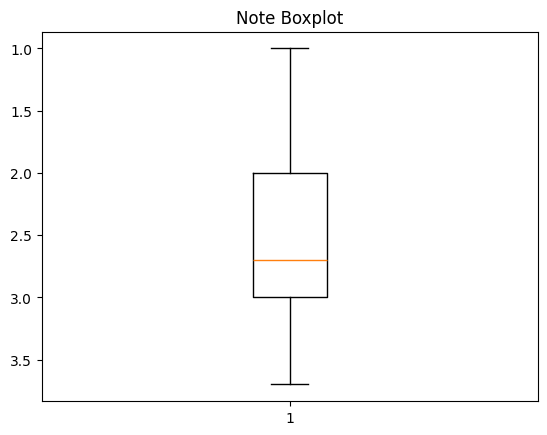

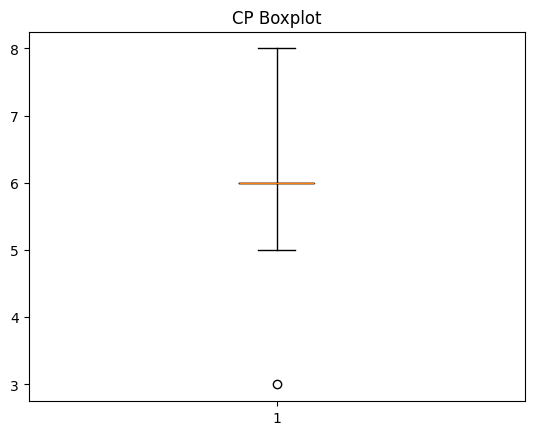

In [6]:
fig1, ax1 = plt.subplots()
ax1.set_title('Note Boxplot')
ax1.boxplot(grades_df['Note'])
ax1.invert_yaxis()

fig2, ax2 = plt.subplots()
ax2.set_title('CP Boxplot')
# Adjust whisker lengths to the 5th and 95th percentiles. If they were at the standard (1.5*IQR), it would look 
# less like a box plot as most of the data has the value 6 in my case. Feel free to adjust this to whatever suits your needs. 
# One has to note, that adjusting whiskers shouldn't be done hapharzadly and should always be explicitly documented
# 
ax2.boxplot(grades_df['CP'], whis=[5, 95])
plt.show()


We would like to create a linear regression model as to predict future performance. We choose the month in which the exam was written and the days since the first exam ever written. We extract both of these from our data and create a model based on the entire training set.

We then plug each date in our data set into the model and generate the plot "Linear Regression".

We generate the days from the first exam until 2025 and plug them into the model, this gives us the plot "Prediction"

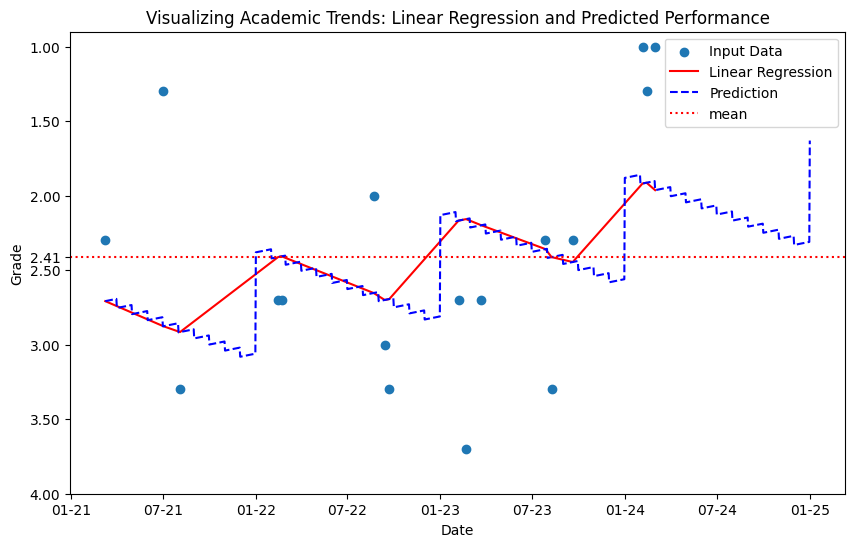

In [9]:

# Convert dates to numeric representation (number of days since a reference date)
grades_df['NumericDate'] = (grades_df['Datum'] - grades_df['Datum'].min()).dt.days

# Extract month from dates
grades_df['Month'] = grades_df['Datum'].dt.month

# Prepare data
X = grades_df[['NumericDate', 'Month']]
y = grades_df['Note']

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict grades using the model
predicted_grades = model.predict(X)

# Extend dates into the future until 2025
future_dates = pd.date_range(start=grades_df['Datum'].min(), end='2025-01-01')

# Convert future dates to numeric representation
future_numeric_dates = (future_dates - grades_df['Datum'].min()).days
future_month = future_dates.month

# Combine future numeric dates and month into a DataFrame with consistent feature names
future_X = pd.DataFrame({'NumericDate': future_numeric_dates, 'Month': future_month})

# Predict grades for future dates
future_predicted_grades = model.predict(future_X)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data as a scatter plot
ax.scatter(grades_df['Datum'], grades_df['Note'], label='Input Data')

# Plot regression line for existing data
ax.plot(grades_df['Datum'], predicted_grades, color='red', label='Linear Regression')

# Plot extension of regression line into the future
ax.plot(future_dates, future_predicted_grades, color='blue', linestyle='--', label='Prediction')

#Plot the mean grade as a horizontal line
ax.axhline(mean_grade, color="red", linestyle=":",label="mean")
ax.set_yticks([mean_grade,1,1.5,2,2.5,3,3.5,4])

# Set date format to display only month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

# Set the y-axis range
ax.set_ylim(0.9, 4)

# Reverse the y-axis
ax.invert_yaxis()

# Set title, labels and legend
ax.set_title('Visualizing Academic Trends: Linear Regression and Predicted Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Grade')
ax.legend()

# Show plot
plt.show()


Let us have a final look at our data, we started of with 4 DataFrames and 7 Series and were left with 1 DataFrame and 9 Series. Thank you for reading through this; it was a fun project.

In [8]:
print(grades_df.shape)
grades_df

(17, 9)


,Module/Fächer,Note,Vm,Ang,CP,Datum,Sem,NumericDate,Month
0,Einführung in die Technische Informatik,2.3,BE,N,6.0,2021-03-09,20W,0,3
1,"Data, Algorithms and Society",1.3,BE,N,3.0,2021-07-02,21S,115,7
2,Betriebssysteme und Systemsoftware,3.3,BE,N,6.0,2021-08-04,21S,148,8
3,Softwaretechnik,2.7,BE,N,6.0,2022-02-14,21W,342,2
4,Grundlagen des Management,2.7,BE,N,5.0,2022-02-21,21W,349,2
5,"Formale Systeme, Automaten, Prozesse",2.0,BE,N,6.0,2022-08-22,22S,531,8
6,Datenstrukturen und Algorithmen,3.0,BE,N,8.0,2022-09-13,22S,553,9
7,Quantitative Methoden (Operations Research),3.3,BE,N,5.0,2022-09-22,22S,562,9
8,Datenkommunikation,2.7,BE,N,6.0,2023-02-06,22W,699,2
9,"Berechenbarkeit und Komplexität (neu, WS)",3.7,BE,N,7.0,2023-02-21,22W,714,2
